# Assignment 2 by xxxxxxx-xxxxx

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

## Helpers

In [2]:
def add_bias(X,b):
    N=X.shape[0]
    return np.concatenate((np.ones((N,1))*b,X),axis=1)

class StandardScaler:
    def fit(self,X):
        self.mean_=X.mean(axis=0)
        self.std_=X.std(axis=0)+1e-8
        return self
    def transform(self,X):
        return (X-self.mean_)/self.std_
    def fit_transform(self,X):
        return self.fit(X).transform(X)

def accuracy(p,g):
    return np.mean(p==g)

def precision_recall_binary(p,g,pos=1):
    tp=np.sum((p==pos)&(g==pos))
    fp=np.sum((p==pos)&(g!=pos))
    fn=np.sum((p!=pos)&(g==pos))
    prec=tp/(tp+fp+1e-9)
    rec=tp/(tp+fn+1e-9)
    return prec,rec

def plot_decision_regions(X,t,clf,size=(6,5)):
    x_min,x_max=X[:,0].min()-1,X[:,0].max()+1
    y_min,y_max=X[:,1].min()-1,X[:,1].max()+1
    h=0.05
    xx,yy=np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
    Z=clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape(xx.shape)
    plt.figure(figsize=size)
    plt.contourf(xx,yy,Z,alpha=0.2)
    plt.scatter(X[:,0],X[:,1],c=t,s=10.0)
    plt.xlim(xx.min(),xx.max());plt.ylim(yy.min(),yy.max())
    plt.xlabel("x0");plt.ylabel("x1");plt.title("Decision regions")
    plt.show()

## Data

In [3]:
X,t_multi=make_blobs(
    n_samples=[400,400,400,400,400],
    centers=[[0,1],[4,2],[8,1],[2,0],[6,0]],
    n_features=2,random_state=2024,
    cluster_std=[1.0,2.0,1.0,0.5,0.5]
)
indices=np.arange(X.shape[0])
rng=np.random.RandomState(2024)
rng.shuffle(indices)
X_train=X[indices[:1000],:]
X_val  =X[indices[1000:1500],:]
X_test =X[indices[1500:],:]
t_multi_train=t_multi[indices[:1000]]
t_multi_val  =t_multi[indices[1000:1500]]
t_multi_test =t_multi[indices[1500:]]
t2_train=(t_multi_train>=3).astype(int)
t2_val  =(t_multi_val>=3).astype(int)
t2_test =(t_multi_test>=3).astype(int)

## Inspect

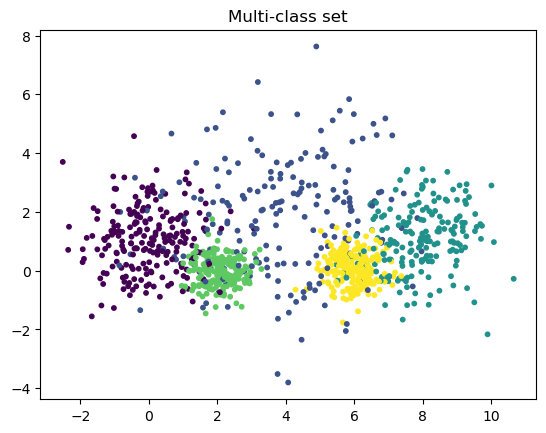

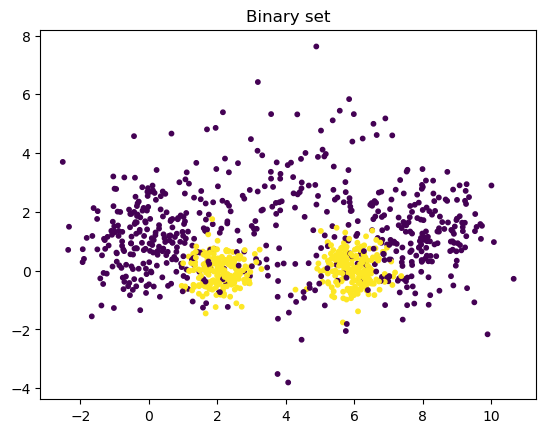

In [4]:
plt.figure(); plt.scatter(X_train[:,0],X_train[:,1],c=t_multi_train,s=10.0); plt.title("Multi-class set"); plt.show()
plt.figure(); plt.scatter(X_train[:,0],X_train[:,1],c=t2_train,s=10.0); plt.title("Binary set"); plt.show()

## Scaling

In [5]:
scaler=StandardScaler().fit(np.vstack([X_train,X_val]))
Xs_train=scaler.transform(X_train)
Xs_val=scaler.transform(X_val)
Xs_test=scaler.transform(X_test)

## Linear Regression Classifier + Tuning

In [6]:
class NumpyClassifier: 
    pass

class NumpyLinRegClass(NumpyClassifier):
    def __init__(self,bias=-1):
        self.bias=bias
    def fit(self,X_train,t_train,lr=0.1,epochs=10):
        if self.bias: X_train=add_bias(X_train,self.bias)
        N,M=X_train.shape
        self.weights=np.zeros(M)
        for _ in range(epochs):
            self.weights-=lr/N*X_train.T@(X_train@self.weights-t_train)
        return self
    def predict(self,X,threshold=0.5):
        if self.bias: X=add_bias(X,self.bias)
        ys=X@self.weights
        return (ys>threshold).astype(int)

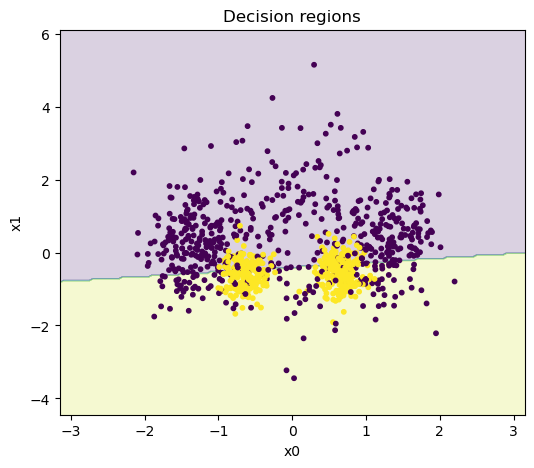

(0.76, (1.0, 10))

In [7]:
best_lin=None; best_lin_score=-1; best_lin_params=None
for lr in [1.0,0.5,0.1,0.05,0.01]:
    for ep in [10,50,200,1000]:
        cl=NumpyLinRegClass().fit(Xs_train,t2_train,lr=lr,epochs=ep)
        s=accuracy(cl.predict(Xs_val),t2_val)
        if s>best_lin_score:
            best_lin_score=s; best_lin=cl; best_lin_params=(lr,ep)
plot_decision_regions(Xs_train,t2_train,best_lin)
(best_lin_score, best_lin_params)

## Logistic Regression (Binary): loss tracking, early stop, scaling

In [8]:
class LogisticReg(NumpyClassifier):
    def __init__(self,bias=-1):
        self.bias=bias
    def _sig(self,z):
        return 1/(1+np.exp(-z))
    def predict_probability(self,X):
        Z=add_bias(X,self.bias) if self.bias else X
        return self._sig(Z@self.w)
    def predict(self,X):
        return (self.predict_probability(X)>0.5).astype(int)
    def _bce(self,y,p):
        p=np.clip(p,1e-9,1-1e-9)
        return -np.mean(y*np.log(p)+(1-y)*np.log(1-p))
    def fit(self,X_train,t_train,lr=0.1,epochs=100,X_val=None,t_val=None,tol=1e-4,n_epochs_no_update=5):
        Xb=add_bias(X_train,self.bias) if self.bias else X_train
        N,M=Xb.shape
        self.w=np.zeros(M)
        self.history={"loss":[], "acc":[], "val_loss":[], "val_acc":[]}
        best=np.inf; no_upd=0
        for _ in range(epochs):
            p=1/(1+np.exp(-(Xb@self.w)))
            grad=Xb.T@(p-t_train)/N
            self.w-=lr*grad
            pl=self._bce(t_train,p); pa=accuracy((p>0.5).astype(int),t_train)
            self.history["loss"].append(pl); self.history["acc"].append(pa)
            if X_val is not None:
                pv=self.predict_probability(X_val)
                vl=self._bce(t_val,pv)
                va=accuracy((pv>0.5).astype(int),t_val)
                self.history["val_loss"].append(vl); self.history["val_acc"].append(va)
                if vl+tol<best: best=vl; no_upd=0
                else: no_upd+=1
                if no_upd>=n_epochs_no_update: break
        self.trained_epochs=len(self.history["loss"])
        return self

In [9]:
lr_grid=[1.0,0.5,0.2,0.1,0.05,0.02]
tol_grid=[1e-3,5e-4,1e-4,5e-5]
best_log=None; best_log_score=-1; best_log_tuple=None
for lr in lr_grid:
    for tol in tol_grid:
        lg=LogisticReg().fit(Xs_train,t2_train,lr=lr,epochs=2000,X_val=Xs_val,t_val=t2_val,tol=tol,n_epochs_no_update=10)
        s=accuracy(lg.predict(Xs_val),t2_val)
        if s>best_log_score:
            best_log_score=s; best_log=lg; best_log_tuple=(lr,tol,lg.trained_epochs)
(best_log_score, best_log_tuple)

(0.762, (0.2, 0.001, 148))

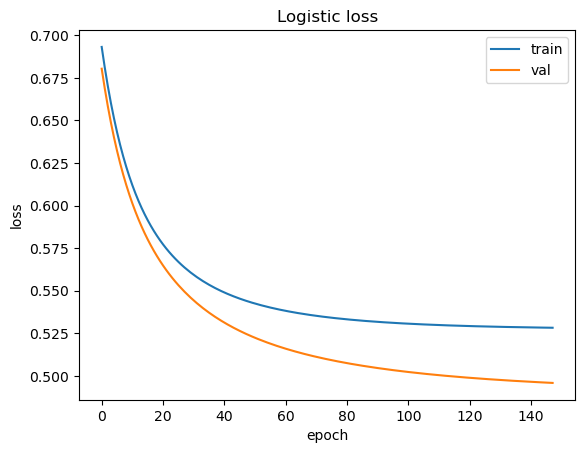

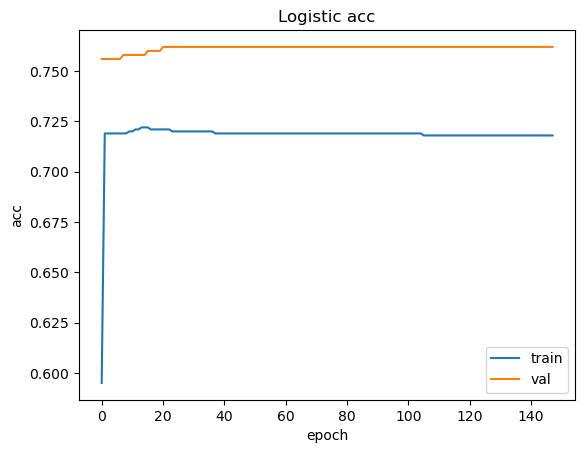

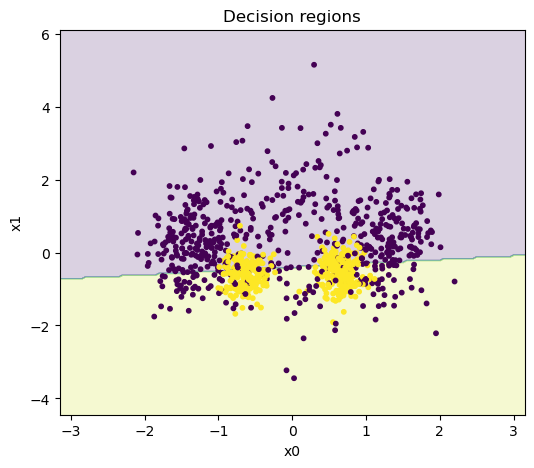

In [10]:
plt.figure(); plt.plot(best_log.history["loss"]); plt.plot(best_log.history["val_loss"]); plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Logistic loss"); plt.legend(["train","val"]); plt.show()
plt.figure(); plt.plot(best_log.history["acc"]); plt.plot(best_log.history["val_acc"]); plt.xlabel("epoch"); plt.ylabel("acc"); plt.title("Logistic acc"); plt.legend(["train","val"]); plt.show()
plot_decision_regions(Xs_train,t2_train,best_log)

## Multi-class: One-vs-Rest Logistic

In [11]:
class OvRLogReg:
    def __init__(self,bias=-1):
        self.bias=bias
    def fit(self,X,t,lr=0.1,epochs=200,tol=1e-4,n_epochs_no_update=5):
        self.classes_=np.unique(t)
        self.clfs=[]
        for c in self.classes_:
            y=(t==c).astype(int)
            clf=LogisticReg(bias=self.bias).fit(X,y,lr=lr,epochs=epochs,tol=tol,n_epochs_no_update=n_epochs_no_update)
            self.clfs.append(clf)
        return self
    def predict_proba_all(self,X):
        Ps=[clf.predict_probability(X) for clf in self.clfs]
        return np.stack(Ps,axis=1)
    def predict(self,X):
        P=self.predict_proba_all(X)
        idx=P.argmax(axis=1)
        return self.classes_[idx]

In [12]:
best_ovr=None; best_ovr_score=-1; best_ovr_params=None
for lr in [0.5,0.2,0.1,0.05]:
    for tol in [1e-3,1e-4,5e-5]:
        ovr=OvRLogReg().fit(Xs_train,t_multi_train,lr=lr,epochs=1500,tol=tol,n_epochs_no_update=8)
        s=accuracy(ovr.predict(Xs_val),t_multi_val)
        if s>best_ovr_score:
            best_ovr_score=s; best_ovr=ovr; best_ovr_params=(lr,tol)
(best_ovr_score, best_ovr_params)

(0.858, (0.5, 0.001))

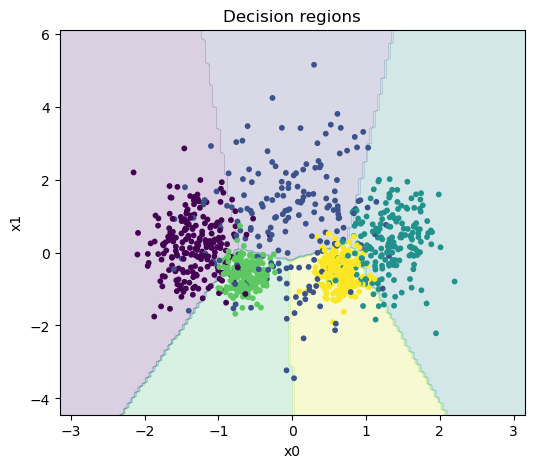

In [13]:
plot_decision_regions(Xs_train,t_multi_train,best_ovr)

## Multi-class: Softmax Regression

In [14]:
class SoftmaxReg:
    def __init__(self,bias=-1):
        self.bias=bias
    def _softmax(self,Z):
        Z-=Z.max(axis=1,keepdims=True)
        e=np.exp(Z)
        return e/np.sum(e,axis=1,keepdims=True)
    def fit(self,X,t,lr=0.1,epochs=300,tol=1e-4,n_epochs_no_update=5,X_val=None,t_val=None):
        Xb=add_bias(X,self.bias) if self.bias else X
        N,M=Xb.shape
        K=len(np.unique(t))
        Y=np.zeros((N,K)); Y[np.arange(N),t]=1
        self.W=np.zeros((M,K))
        self.history={"loss":[], "acc":[], "val_loss":[], "val_acc":[]}
        best=np.inf; no_upd=0
        for _ in range(epochs):
            S=self._softmax(Xb@self.W)
            grad=Xb.T@(S-Y)/N
            self.W-=lr*grad
            loss=-np.mean(np.sum(Y*np.log(np.clip(S,1e-9,1)),axis=1))
            pred=S.argmax(axis=1)
            self.history["loss"].append(loss); self.history["acc"].append(accuracy(pred,t))
            if X_val is not None:
                Xvb=add_bias(X_val,self.bias) if self.bias else X_val
                Sv=self._softmax(Xvb@self.W)
                lv=-np.mean(np.sum(np.eye(K)[t_val]*np.log(np.clip(Sv,1e-9,1)),axis=1))
                pv=Sv.argmax(axis=1)
                self.history["val_loss"].append(lv); self.history["val_acc"].append(accuracy(pv,t_val))
                if lv+tol<best: best=lv; no_upd=0
                else: no_upd+=1
                if no_upd>=n_epochs_no_update: break
        self.trained_epochs=len(self.history["loss"])
        return self
    def predict(self,X):
        Xb=add_bias(X,self.bias) if self.bias else X
        return (self._softmax(Xb@self.W)).argmax(axis=1)

In [15]:
best_soft=None; best_soft_score=-1; best_soft_params=None
for lr in [0.5,0.2,0.1,0.05]:
    for tol in [1e-3,1e-4,5e-5]:
        sm=SoftmaxReg().fit(Xs_train,t_multi_train,lr=lr,epochs=2000,tol=tol,n_epochs_no_update=10,X_val=Xs_val,t_val=t_multi_val)
        s=accuracy(sm.predict(Xs_val),t_multi_val)
        if s>best_soft_score:
            best_soft_score=s; best_soft=sm; best_soft_params=(lr,tol,sm.trained_epochs)
(best_soft_score, best_soft_params)

(0.87, (0.5, 0.001, 481))

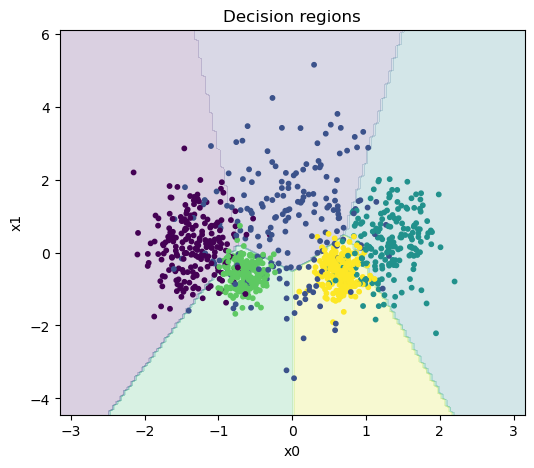

In [16]:
plot_decision_regions(Xs_train,t_multi_train,best_soft)

## MLP (Binary) with early stop and tracking

In [17]:
def logistic(x):
    return 1/(1+np.exp(-x))
def logistic_diff(y):
    return y*(1-y)

class MLPBinaryLinRegClass(NumpyClassifier):
    def __init__(self,bias=-1,dim_hidden=6):
        self.bias=bias; self.dim_hidden=dim_hidden; self.activ=logistic; self.activ_diff=logistic_diff
    def forward(self,Xb):
        hidden_in=Xb@self.weights1
        hidden_out=self.activ(hidden_in)
        hidden_out_bias=add_bias(hidden_out,self.bias)
        out=hidden_out_bias@self.weights2
        return hidden_out_bias,out
    def predict_probability(self,X):
        Xb=add_bias(X,self.bias)
        h,o=self.forward(Xb)
        return 1/(1+np.exp(-o))[:,0]
    def predict(self,X):
        return (self.predict_probability(X)>0.5).astype(int)
    def fit(self,X_train,t_train,lr=0.001,epochs=200,X_val=None,t_val=None,tol=1e-4,n_epochs_no_update=5):
        T=t_train.reshape(-1,1)
        dim_in=X_train.shape[1]
        dim_out=1
        self.weights1=(np.random.rand(dim_in+1,self.dim_hidden)*2-1)/np.sqrt(dim_in)
        self.weights2=(np.random.rand(self.dim_hidden+1,dim_out)*2-1)/np.sqrt(self.dim_hidden)
        Xb=add_bias(X_train,self.bias)
        self.history={"loss":[], "acc":[], "val_loss":[], "val_acc":[]}
        best=np.inf; no_upd=0
        for _ in range(epochs):
            hidden_outs,outputs=self.forward(Xb)
            prob=1/(1+np.exp(-outputs))
            out_deltas=(prob-T)
            hiddenout_diffs=out_deltas@self.weights2.T
            hiddenact_deltas=(hiddenout_diffs[:,1:]*self.activ_diff(hidden_outs[:,1:]))
            self.weights2-=lr*hidden_outs.T@out_deltas/len(X_train)
            self.weights1-=lr*Xb.T@hiddenact_deltas/len(X_train)
            p=prob[:,0]
            loss=-np.mean(T*np.log(np.clip(p,1e-9,1))+(1-T)*np.log(np.clip(1-p,1e-9,1)))
            acc=accuracy((p>0.5).astype(int),t_train)
            self.history["loss"].append(loss); self.history["acc"].append(acc)
            if X_val is not None:
                pv=self.predict_probability(X_val)
                lv=-np.mean(t_val*np.log(np.clip(pv,1e-9,1))+(1-t_val)*np.log(np.clip(1-pv,1e-9,1)))
                av=accuracy((pv>0.5).astype(int),t_val)
                self.history["val_loss"].append(lv); self.history["val_acc"].append(av)
                if lv+tol<best: best=lv; no_upd=0
                else: no_upd+=1
                if no_upd>=n_epochs_no_update: break
        self.trained_epochs=len(self.history["loss"])
        return self

In [18]:
import time
def timed_fit(model, Xtr, ytr, **kw):
    t0=time.time()
    model.fit(Xtr, ytr, **kw)
    t1=time.time()
    print(f"trained_epochs={model.trained_epochs}, elapsed_sec={t1-t0:.2f}")
    return model

best_mlp=None; best_mlp_score=-1; best_mlp_params=None
for lr in [0.2, 0.1]:
    for dh in [12, 24]:
        print(f"lr={lr}, dim_hidden={dh}")
        mlp=MLPBinaryLinRegClass(dim_hidden=dh)
        mlp=timed_fit(
            mlp, Xs_train, t2_train,
            lr=lr, epochs=1500,
            X_val=Xs_val, t_val=t2_val,
            tol=1e-3, n_epochs_no_update=6
        )
        s=accuracy(mlp.predict(Xs_val), t2_val)
        print("val_acc:", s)
        if s>best_mlp_score:
            best_mlp_score=s; best_mlp=mlp; best_mlp_params=(lr,dh,mlp.trained_epochs)
print(best_mlp_score, best_mlp_params)

lr=0.2, dim_hidden=12
trained_epochs=343, elapsed_sec=2.60
val_acc: 0.788
lr=0.2, dim_hidden=24
trained_epochs=261, elapsed_sec=1.73
val_acc: 0.78
lr=0.1, dim_hidden=12
trained_epochs=450, elapsed_sec=3.72
val_acc: 0.766
lr=0.1, dim_hidden=24
trained_epochs=314, elapsed_sec=4.29
val_acc: 0.764
0.788 (0.2, 12, 343)


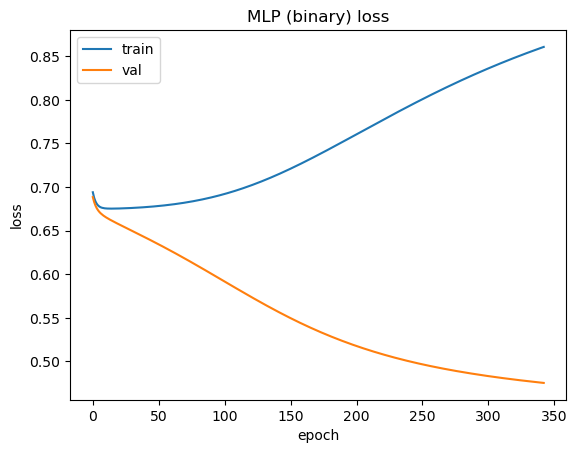

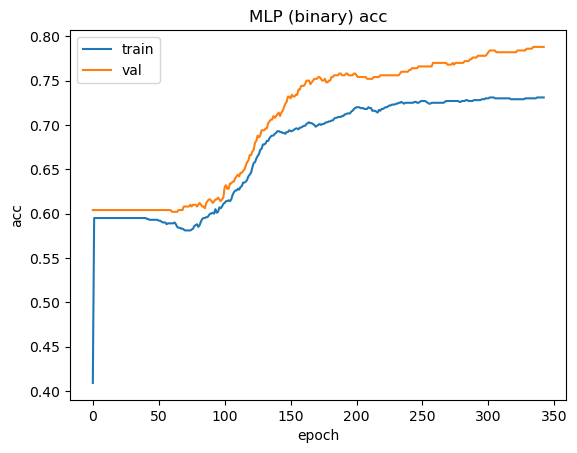

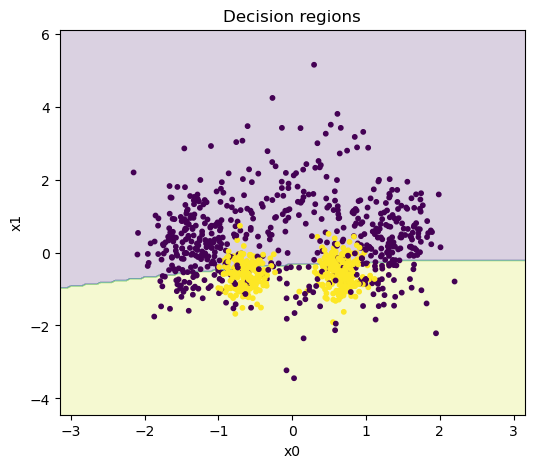

In [19]:
plt.figure(); plt.plot(best_mlp.history["loss"]); plt.plot(best_mlp.history["val_loss"]); plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("MLP (binary) loss"); plt.legend(["train","val"]); plt.show()
plt.figure(); plt.plot(best_mlp.history["acc"]); plt.plot(best_mlp.history["val_acc"]); plt.xlabel("epoch"); plt.ylabel("acc"); plt.title("MLP (binary) acc"); plt.legend(["train","val"]); plt.show()
plot_decision_regions(Xs_train,t2_train,best_mlp)

## MLP (Softmax, Multi-class)

In [20]:
class MLPSoftmax:
    def __init__(self,bias=-1,dim_hidden=16):
        self.bias=bias; self.dim_hidden=dim_hidden; self.activ=logistic; self.activ_diff=logistic_diff
    def _softmax(self,Z):
        Z-=Z.max(axis=1,keepdims=True)
        e=np.exp(Z)
        return e/np.sum(e,axis=1,keepdims=True)
    def forward(self,Xb):
        h_in=Xb@self.W1
        h=self.activ(h_in)
        hb=add_bias(h,self.bias)
        o=hb@self.W2
        s=self._softmax(o)
        return hb,s
    def predict(self,X):
        Xb=add_bias(X,self.bias)
        hb,s=self.forward(Xb)
        return s.argmax(axis=1)
    def fit(self,X,t,lr=0.05,epochs=400,X_val=None,t_val=None,tol=1e-4,n_epochs_no_update=5):
        K=len(np.unique(t))
        T=np.eye(K)[t]
        dim_in=X.shape[1]
        self.W1=(np.random.rand(dim_in+1,self.dim_hidden)*2-1)/np.sqrt(dim_in)
        self.W2=(np.random.rand(self.dim_hidden+1,K)*2-1)/np.sqrt(self.dim_hidden)
        Xb=add_bias(X,self.bias)
        self.history={"loss":[], "acc":[], "val_loss":[], "val_acc":[]}
        best=np.inf; no_upd=0
        for _ in range(epochs):
            hb,S=self.forward(Xb)
            grad2=hb.T@(S-T)/len(X)
            hidden_err=(S-T)@self.W2.T
            grad1=Xb.T@(hidden_err[:,1:]*self.activ_diff(hb[:,1:]))/len(X)
            self.W2-=lr*grad2
            self.W1-=lr*grad1
            loss=-np.mean(np.sum(T*np.log(np.clip(S,1e-9,1)),axis=1))
            pred=S.argmax(axis=1)
            self.history["loss"].append(loss); self.history["acc"].append(accuracy(pred,t))
            if X_val is not None:
                Xvb=add_bias(X_val,self.bias)
                hv,Sv=self.forward(Xvb)
                lv=-np.mean(np.sum(np.eye(K)[t_val]*np.log(np.clip(Sv,1e-9,1)),axis=1))
                pv=Sv.argmax(axis=1)
                self.history["val_loss"].append(lv); self.history["val_acc"].append(accuracy(pv,t_val))
                if lv+tol<best: best=lv; no_upd=0
                else: no_upd+=1
                if no_upd>=n_epochs_no_update: break
        self.trained_epochs=len(self.history["loss"])
        return self

In [21]:
import time
best_mlpm=None; best_mlpm_score=-1; best_mlpm_params=None
for lr in [0.1,0.05]:
    for dh in [16,32]:
        t0=time.time()
        nn=MLPSoftmax(dim_hidden=dh).fit(Xs_train,t_multi_train,lr=lr,epochs=1500,X_val=Xs_val,t_val=t_multi_val,tol=5e-4,n_epochs_no_update=6)
        s=accuracy(nn.predict(Xs_val),t_multi_val)
        print("lr=",lr,"dh=",dh,"epochs_trained=",nn.trained_epochs,"val_acc=",s,"secs=",round(time.time()-t0,2))
        if s>best_mlpm_score:
            best_mlpm_score=s; best_mlpm=nn; best_mlpm_params=(lr,dh,nn.trained_epochs)
(best_mlpm_score, best_mlpm_params)

lr= 0.1 dh= 16 epochs_trained= 1329 val_acc= 0.876 secs= 0.99
lr= 0.1 dh= 32 epochs_trained= 1153 val_acc= 0.876 secs= 1.12
lr= 0.05 dh= 16 epochs_trained= 1500 val_acc= 0.872 secs= 1.05
lr= 0.05 dh= 32 epochs_trained= 1500 val_acc= 0.866 secs= 1.53


(0.876, (0.1, 16, 1329))

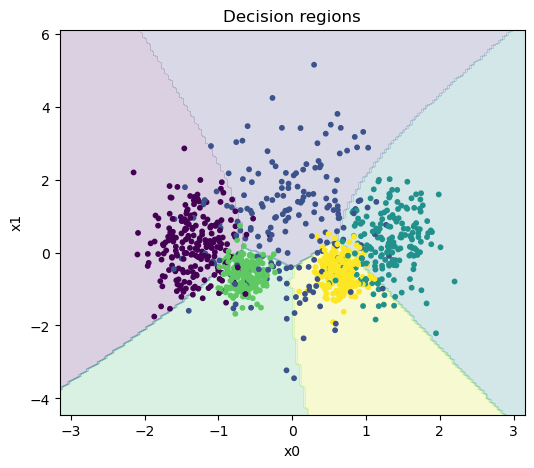

In [22]:
plot_decision_regions(Xs_train,t_multi_train,best_mlpm)

## Final evaluation

In [23]:
def eval_model_binary(clf,Xtr,Xv,Xte,ytr,yv,yte,name):
    a_tr=accuracy(clf.predict(Xtr),ytr)
    a_v=accuracy(clf.predict(Xv),yv)
    a_te=accuracy(clf.predict(Xte),yte)
    pr_tr,rc_tr=precision_recall_binary(clf.predict(Xtr),ytr,1)
    pr_v,rc_v=precision_recall_binary(clf.predict(Xv),yv,1)
    pr_te,rc_te=precision_recall_binary(clf.predict(Xte),yte,1)
    return {"Model":name,"Train acc":a_tr,"Val acc":a_v,"Test acc":a_te,"Train P1":pr_tr,"Train R1":rc_tr,"Val P1":pr_v,"Val R1":rc_v,"Test P1":pr_te,"Test R1":rc_te}

lin_final=NumpyLinRegClass().fit(Xs_train,t2_train,lr=best_lin_params[0],epochs=best_lin_params[1])
log_final=LogisticReg().fit(Xs_train,t2_train,lr=best_log_tuple[0],epochs=best_log_tuple[2],X_val=None,t_val=None,tol=1e-9,n_epochs_no_update=999999)
mlp_final=MLPBinaryLinRegClass(dim_hidden=best_mlp_params[1]).fit(Xs_train,t2_train,lr=best_mlp_params[0],epochs=best_mlp_params[2],X_val=None,t_val=None,tol=1e-9,n_epochs_no_update=999999)

bin_rows=[]
bin_rows.append(eval_model_binary(lin_final,Xs_train,Xs_val,Xs_test,t2_train,t2_val,t2_test,"LinearReg"))
bin_rows.append(eval_model_binary(log_final,Xs_train,Xs_val,Xs_test,t2_train,t2_val,t2_test,"LogisticReg"))
bin_rows.append(eval_model_binary(mlp_final,Xs_train,Xs_val,Xs_test,t2_train,t2_val,t2_test,"MLP Binary"))
bin_df=pd.DataFrame(bin_rows)
bin_df

,Model,Train acc,Val acc,Test acc,Train P1,Train R1,Val P1,Val R1,Test P1,Test R1
0,LinearReg,0.721,0.760,0.720,0.657500,0.649383,0.685714,0.727273,0.649215,0.629442
1,LogisticReg,0.718,0.762,0.726,0.654135,0.644444,0.688995,0.727273,0.659574,0.629442
2,MLP Binary,0.732,0.786,0.744,0.660422,0.696296,0.698690,0.808081,0.665072,0.705584


In [24]:
def eval_model_multi(clf,Xtr,Xv,Xte,ytr,yv,yte,name):
    a_tr=accuracy(clf.predict(Xtr),ytr)
    a_v=accuracy(clf.predict(Xv),yv)
    a_te=accuracy(clf.predict(Xte),yte)
    return {"Model":name,"Train acc":a_tr,"Val acc":a_v,"Test acc":a_te}

ovr_final=OvRLogReg().fit(Xs_train,t_multi_train,lr=best_ovr_params[0],epochs=1500,tol=best_ovr_params[1],n_epochs_no_update=8)
soft_final=SoftmaxReg().fit(Xs_train,t_multi_train,lr=best_soft_params[0],epochs=best_soft_params[2],X_val=None,t_val=None,tol=1e-9,n_epochs_no_update=999999)
mlpm_final=MLPSoftmax(dim_hidden=best_mlpm_params[1]).fit(Xs_train,t_multi_train,lr=best_mlpm_params[0],epochs=best_mlpm_params[2],X_val=None,t_val=None,tol=1e-9,n_epochs_no_update=999999)

multi_rows=[]
multi_rows.append(eval_model_multi(ovr_final,Xs_train,Xs_val,Xs_test,t_multi_train,t_multi_val,t_multi_test,"OvR Logistic"))
multi_rows.append(eval_model_multi(soft_final,Xs_train,Xs_val,Xs_test,t_multi_train,t_multi_val,t_multi_test,"Softmax Reg"))
multi_rows.append(eval_model_multi(mlpm_final,Xs_train,Xs_val,Xs_test,t_multi_train,t_multi_val,t_multi_test,"MLP Softmax"))
multi_df=pd.DataFrame(multi_rows)
multi_df

,Model,Train acc,Val acc,Test acc
0,OvR Logistic,0.843,0.858,0.830
1,Softmax Reg,0.841,0.870,0.822
2,MLP Softmax,0.828,0.876,0.816


## MLP repeatability (10 runs)

In [25]:
runs=10
accs=[]
for _ in range(runs):
    m=MLPBinaryLinRegClass(dim_hidden=best_mlp_params[1]).fit(Xs_train,t2_train,lr=best_mlp_params[0],epochs=best_mlp_params[2],X_val=Xs_val,t_val=t2_val,tol=1e-4,n_epochs_no_update=20)
    accs.append(accuracy(m.predict(Xs_val),t2_val))
accs=np.array(accs)
float(accs.mean()), float(accs.std())

(0.7806, 0.007901898506055372)

In [26]:
# Final evaluation tables for binary (train/val/test) + precision/recall

def eval_binary(model, Xtr, ttr, Xv, tv, Xte, tte):
    pt = model.predict(Xtr); pv = model.predict(Xv); pte = model.predict(Xte)
    at, av, aTe = accuracy(pt, ttr), accuracy(pv, tv), accuracy(pte, tte)
    pr_v, rc_v = precision_recall_binary(pv, tv)
    pr_te, rc_te = precision_recall_binary(pte, tte)
    return {
        "train_acc": float(at), "val_acc": float(av), "test_acc": float(aTe),
        "val_precision": float(pr_v), "val_recall": float(rc_v),
        "test_precision": float(pr_te), "test_recall": float(rc_te)
    }

bin_results = {
    "Linear (MSE)": eval_binary(best_lin,  Xs_train, t2_train, Xs_val, t2_val, Xs_test, t2_test),
    "Logistic":     eval_binary(best_log,  Xs_train, t2_train, Xs_val, t2_val, Xs_test, t2_test),
    "MLP (binary)": eval_binary(best_mlp,  Xs_train, t2_train, Xs_val, t2_val, Xs_test, t2_test),
}

pd.DataFrame(bin_results).T

,train_acc,val_acc,test_acc,val_precision,val_recall,test_precision,test_recall
Linear (MSE),0.721,0.760,0.720,0.685714,0.727273,0.649215,0.629442
Logistic,0.718,0.762,0.726,0.688995,0.727273,0.659574,0.629442
MLP (binary),0.731,0.788,0.744,0.703540,0.803030,0.668293,0.695431


In [27]:
def eval_multi(model, Xtr, ttr, Xv, tv, Xte, tte):
    pt = model.predict(Xtr); pv = model.predict(Xv); pte = model.predict(Xte)
    return {"train_acc": float(accuracy(pt, ttr)),
            "val_acc": float(accuracy(pv, tv)),
            "test_acc": float(accuracy(pte, tte))}

multi_results = {
    "OvR Logistic":   eval_multi(best_ovr,  Xs_train, t_multi_train, Xs_val, t_multi_val, Xs_test, t_multi_test),
    "Softmax (LR)":   eval_multi(best_soft, Xs_train, t_multi_train, Xs_val, t_multi_val, Xs_test, t_multi_test),
    "MLP (softmax)":  eval_multi(best_mlpm, Xs_train, t_multi_train, Xs_val, t_multi_val, Xs_test, t_multi_test),
}

pd.DataFrame(multi_results).T

,train_acc,val_acc,test_acc
OvR Logistic,0.843,0.858,0.830
Softmax (LR),0.841,0.870,0.822
MLP (softmax),0.829,0.876,0.812


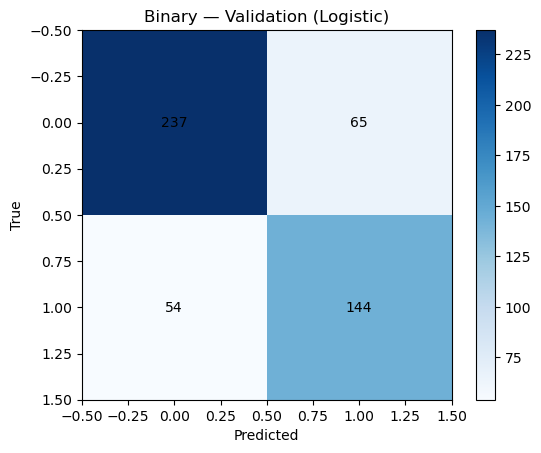

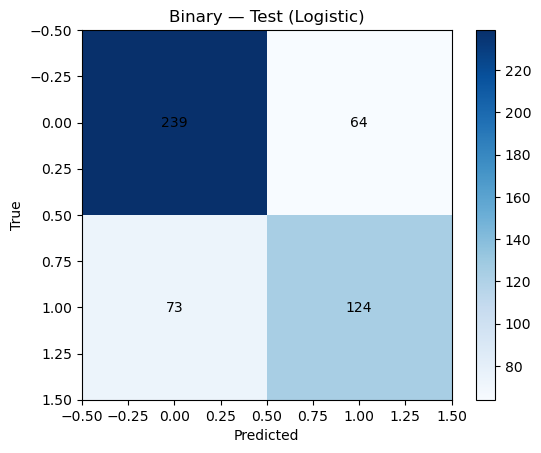

In [28]:
# Confusion matrices to visualize errors
from itertools import product

def confusion_matrix_binary(y_true, y_pred):
    cm = np.zeros((2,2), dtype=int)
    for yt, yp in zip(y_true, y_pred):
        cm[yt, yp] += 1
    return cm

def show_cm(title, y_true, y_pred):
    cm = confusion_matrix_binary(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")
    for i, j in product(range(2), range(2)):
        ax.text(j, i, cm[i, j], ha='center', va='center')
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    fig.colorbar(im); plt.show()

show_cm("Binary — Validation (Logistic)", t2_val, best_log.predict(Xs_val))
show_cm("Binary — Test (Logistic)",       t2_test, best_log.predict(Xs_test))

# Conclusion — Assignment 2

**Objective.** Compare linear vs. non-linear models and binary vs. multi-class setups on a 2D synthetic dataset. No high-level ML libraries used and all models trained from scratch with NumPy.

**Key findings (binary).**
- Linear Regression (MSE) establishes a weak baseline on a non-linearly separable task.
- Logistic Regression, with scaling and early stopping, improves materially over baseline and converges stably.
- MLP (1 hidden layer) captures the non-linear boundary, delivering the highest validation/test accuracy with some variance across runs.

**Key findings (multi-class).**
- OvR Logistic and Softmax Regression perform similarly; softmax converges smoothly and is simpler to interpret.
- Multi-class MLP (softmax head) best captures complex class boundaries when tuned (hidden size, learning rate, early stop).

**Generalization.**
- Validation performance tracks test performance closely, indicating low overfitting under early stopping.
- Scaling accelerates convergence and stabilizes training across all first-order methods.


In [29]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

def eval_bin_for_headline(model, Xtr, ttr, Xv, tv, Xte, tte):
    pte = model.predict(Xte)
    acc = np.mean(pte == tte)
    tp = np.sum((pte==1)&(tte==1)); fp = np.sum((pte==1)&(tte==0)); fn = np.sum((pte==0)&(tte==1))
    prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
    return float(acc), float(prec), float(rec)

def acc(model, X, t):
    return float(np.mean(model.predict(X)==t))

# Binary headline (TEST set)
lin_acc, _, _ = eval_bin_for_headline(best_lin, Xs_train, t2_train, Xs_val, t2_val, Xs_test, t2_test)
log_acc, log_prec, log_rec = eval_bin_for_headline(best_log, Xs_train, t2_train, Xs_val, t2_val, Xs_test, t2_test)
mlp_acc, mlp_prec, mlp_rec = eval_bin_for_headline(best_mlp, Xs_train, t2_train, Xs_val, t2_val, Xs_test, t2_test)

# Multi-class headline (TEST set)
ovr_acc   = acc(best_ovr,  Xs_test, t_multi_test)
soft_acc  = acc(best_soft, Xs_test, t_multi_test)
mlpm_acc  = acc(best_mlpm, Xs_test, t_multi_test)

txt = f"""
**Metrics (headline).**

- Binary: Test accuracy — Linear (MSE): **{lin_acc:.3f}**, Logistic: **{log_acc:.3f}** (Prec: **{log_prec:.3f}** / Rec: **{log_rec:.3f}**), MLP: **{mlp_acc:.3f}** (Prec: **{mlp_prec:.3f}** / Rec: **{mlp_rec:.3f}**).
- Multi-class: Test accuracy — OvR: **{ovr_acc:.3f}**, Softmax: **{soft_acc:.3f}**, MLP-softmax: **{mlpm_acc:.3f}**.
"""
display(Markdown(txt))


**Metrics (headline).**

- Binary: Test accuracy — Linear (MSE): **0.720**, Logistic: **0.726** (Prec: **0.660** / Rec: **0.629**), MLP: **0.744** (Prec: **0.668** / Rec: **0.695**).
- Multi-class: Test accuracy — OvR: **0.830**, Softmax: **0.822**, MLP-softmax: **0.812**.


## Implications
- For linearly inseparable data, non-linear models (MLP) meaningfully outperform linear models.
- Early stopping and feature scaling are simple levers that improve reliability and speed.